# Hough indexing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
from pyebsdindex import ebsd_pattern, ebsd_index, pcopt
from pyebsdindex.EBSDImage import IPFcolor

ImportError: Numba needs NumPy 1.21 or less

### An example of indexing a file of patterns. 
Currently the only types of files that can be indexed are the EDAX UP1/2 files.  HDF5 files should be coming along soon.  

Define the environmental conditions of the data collection

In [3]:
file = '~/Desktop/SLMtest/scan2v3nlparl09sw7.up1'
#file = '~/Desktop/SLMtest/scan2v3lam0.90sr7dt0.0.up1'
PC = np.array([0.46424919, 0.70189953, 0.64026537])
cam_elev = 5.3
sampleTilt = 70.0
vendor = 'EDAX'

Define the radon and indexing parameters

In [4]:
nT = 180 # 180/nTheta == degree resolution 
nR = 90 
tSig = 2.0 # amount of gaussian kernel size in theta in units of radon pixels.
rSig = 1.5 # amount of gassian 2nd derivate in rho in units of radon pixels.
rhomask = 0.1 # fraction of radius to not analyze
backgroundsub = False # enable/disable a simple background subtract of the patterns
nbands = 8
phaselist = ['FCC'] # ['FCC', 'BCC'] #


Now initialize the indexer object.  It is easiest to run it over a 1000 patterns to give some idea of timing.  
Verbose = 1 is only timing, verbose = 2 is radon and peak ID image of last pattern, verbose = 0 nothing is reported. 
Here, "dat1" is a temporary indexed data of the 1000 points.  

The indexer object will hold all the information needed to index a set of patterns.  This includes all the environmental conditions, the radon/band finding parameters, the phase information (including a libray of triplet angles).  The only parameter used are the angles between bands, no bandwidth infomation is currently used/collected.  


Radon Time: 1.7019589940000088
Convolution Time: 0.9665310109999865
Peak ID Time: 0.6379982530000063
Band Label Time: 0.3458765510000035
Total Band Find Time: 3.652405755999993


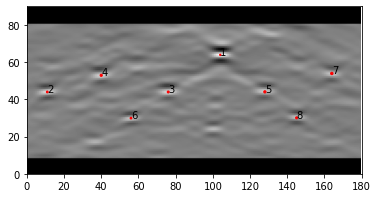

Band Vote Time:  0.5526057400000042


ValueError: not enough values to unpack (expected 3, got 2)

In [6]:
dat1,bnd1, indxer=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 2)
imshape = (indxer.fID.nRows, indxer.fID.nCols)

The data output *dat1* here, is a complex numpy array (or array of structured data), that is \[nphases+1, npoints\].  The data is stored for each phase used in indexing and the dat1\[-1\] layer uses the best guess on which is the most likely phase, based on the fit, and number of bands matched for each phase.  Each data entry contains the orienation expressed as a quaternion (quat) (using EDAX convention by default), Pattern Quality (pq), Cofidence Metric (cm), Phase ID (phase), Fit (fit) and Number of Bands Matched (nmatch).  There are some other metrics reported, but these are mostly for debugging purposes.  

Now use that indexer object to index the whole file.  Setting *npats = -1* will index to the end of the file/array (latter on will be an example of using an array as input).  

The defaults will be to detect all the GPUs on your machine, and use them.  Scheduling is dynamic, so it does not matter if the GPUs are matched. After radon processing/peak finding, the cpus take over for performing the index voting -- thus the number of CPUs needed will depend highly on the number of phases that need to be indexed.  The number of CPUs needed also is dependant on how fast your GPUs are - on my MacPro with a Radeon 6800 GPU there are dimishing returns of including more than 32 CPUs when using the above conditions.  

The *chunksize* is the number of patterns to analyze per process per cycle. The right number here is going to be a function of how much global memory is on your GPU and the size of your patterns and radon arrays.  Setting this very low may have high I/O penalties.  Setting too high will cause your GPU to run out of memory.  In theory this should fall back to the CPU, but this might not work as well as one might hope.  Guidlines: multiples of 16 are most efficient, avoid powers of 2. For patterns that are <= 120 x 120, 784 -- 1008 works OK with a large GPU (>4GB). For 480x620 patterns, chunks of <= 528 are probably more ideal.    

In [5]:
data, bnddata = ebsd_index.index_pats_distributed(filename = file,patstart = 0, npats = -1, chunksize = 1008, ncpu = 42, ebsd_indexer_obj = indxer)

num cpu/gpu: 42 2


2022-05-02 18:08:03,972	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


Display the results as an IPF map.  So far the only implementation is for cubic IPFs - further, more flexible representations are needed here.  

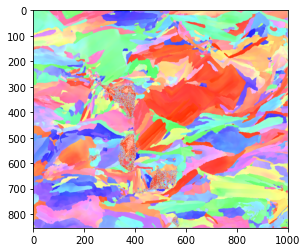

In [6]:
ipfim = IPFcolor.qu2ipf_cubic(data[-1]['quat']).reshape(imshape[0], imshape[1], 3); plt.imshow(ipfim)

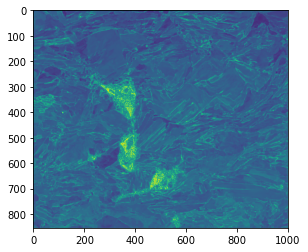

In [7]:
fit = (data[-1]['fit']).reshape(imshape[0],imshape[1]); plt.imshow(fit.clip(0, 2.0))

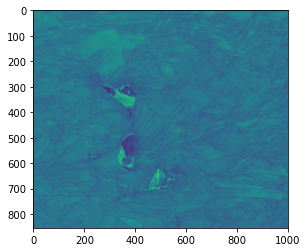

In [8]:
pq = (data[-1]['pq']).reshape(imshape[0],imshape[1]); plt.imshow(pq)

### An example of indexing an array of patterns.

It is also possible to index a numpy array of patterns.  
Here we will read part of the UP file above into an array -- note that patterns can take up a lot of RAM.  It is not normally advisable to read in an entire file of patterns if the filesize is > 2GB.  

Here we read in 200cols x 300 rows = 60000 patterns starting at column 10, row 5 (0-index based) of the EBSD scan data.  However, this is something specific to the UP files (and potentially HDF5 in the future).  What is important here is that the patterns are returned as a *(N, pH, pW)* numpy float32 array where *N* is the number of patterns, *pH* is the pattern height, and *pW* is the pattern width.  

It should be noted that patterns are expected to be arranged so that *pats[0,0,0]* coresponds to the top-left pixel as one looks at the detector towards the sample (same as the EBSD vendor standards and EMSoft version >=5.0). 

(60000, 60, 60)
float32


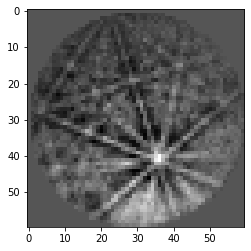

In [9]:
startcolrow = [5,10]
ncol = 200
nrow = 300

f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])
print(pats.shape)
print(pats.dtype)
plt.imshow(pats[0, :, :], cmap='gray')

If the array holds a small number of patterns that can all fit on the GPU at one time, one can avoid the distributed indexing method.  It should be noted that there is built in chuncking (set to fairly conservative limits) to the GPU when using *index_pats*, but no multi-processing of the band voting so it may take a long while.  Here we index just the first 256 patterns. (Note, one does not need to intitate a new indexer object if they have defined one above).  

Radon Time: 1.3742434800000538
Convolution Time: 2.3781266530000025
Peak ID Time: 1.8534996109999256
Band Label Time: 1.9245322579999922
Total Band Find Time: 7.531835003000005


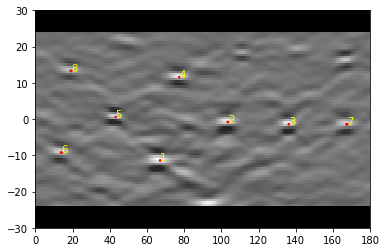

Band Vote Time:  28.996848991


In [10]:
datasm, bnddatsm, indxer=ebsd_index.index_pats(patsIn = pats,
                                     return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, verbose = 2)


If the array is large, then the distributed indexing works on large input arrays as well.  

In [11]:
datasm, bnddatsm = ebsd_index.index_pats_distributed(patsIn = pats,patstart = 0, npats = -1, chunksize = 1008, ncpu = 12, ebsd_indexer_obj = indxer)

num cpu/gpu: 12 2


2022-05-02 18:09:26,456	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


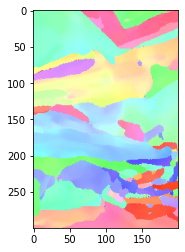

In [12]:
ipfim = IPFcolor.qu2ipf_cubic(datasm[-1]['quat']).reshape(nrow, ncol, 3); plt.imshow(ipfim)

Todo: write an exporter for .ang files and hdf5 files for the indexed data.   

And of course, one can index a single pattern as well.  In this case, *pat* can be a 2D array *(pH, pW)*:

(60, 60)


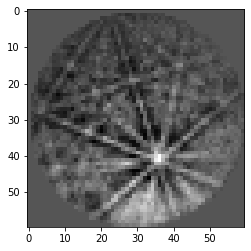

In [13]:
pat1 = pats[0,:, :]
print(pat1.shape)
plt.imshow(pat1, cmap='gray')

Radon Time: 0.007990191999994067
Convolution Time: 0.017679140000012694
Peak ID Time: 0.02271752199999355
Band Label Time: 0.013563085000001252
Total Band Find Time: 0.061964469000002964


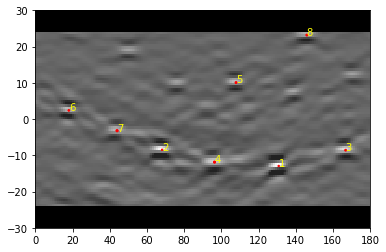

Band Vote Time:  0.0007143899999988435
('quat', 'iq', 'pq', 'cm', 'phase', 'fit', 'nmatch', 'matchattempts', 'totvotes')
[([ 0.65859226, -0.57491329,  0.48512319, -0.01965797], 0., 293405.7, 0.7235495, 0, 0.6052133, 8, [0, 1], 288)]


In [14]:
dat1, bnddat1 = ebsd_index.index_pats(patsIn = pat1, ebsd_indexer_obj = indxer, verbose=2)
dat1 = dat1[-1]
print(dat1.dtype.names)
print(dat1)





It should be noted that this is a pretty slow indexing of one point. It may be prefered to run this all on the CPU instead:

Radon Time: 0.002215457000005472
Convolution Time: 0.0010620650000134901
Peak ID Time: 0.000681822999993642
Band Label Time: 0.011053184999994414
Total Band Find Time: 0.015017620999998371


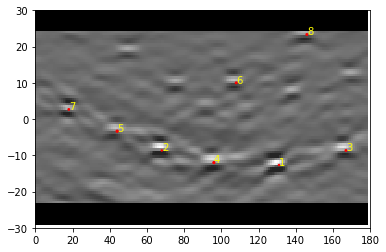

Band Vote Time:  0.0007244390000096246


In [15]:
indxerCPU = copy.deepcopy(indxer)
indxerCPU.bandDetectPlan.useCPU = True
dat1, bnddat1 = ebsd_index.index_pats(patsIn = pat1, ebsd_indexer_obj = indxerCPU, verbose=2)
dat1 = dat1 = dat1[-1]

### An example of optimizing the Pattern Center

There is nothing special here: we use a Nelder-Mead optimization to minimize the fit of the indexed patterns.  

It is built to optimize using a single pattern, or an array of patterns. Note- there are a lot of iterations still, and indexing is single threaded.  It is not recomended to use a very large array of patterns.    

In [16]:
startcolrow = [560,460]
ncol = 60
nrow = 2
f = ebsd_pattern.get_pattern_file_obj(file)
pats = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])

Single pattern optimization:

In [17]:
newPC = pcopt.optimize(pats[0,:,:], indxer, PC0 = [0.45, 0.65, 0.65])
print(newPC)
print(pcopt.optimize(pats[0,:,:], indxer, PC0 = newPC))

[0.46838947 0.70615405 0.64070127]
[0.46844258 0.70618324 0.64076734]


Multiple pattern optimization (here using 120 patterns): 

In [18]:
newPC = pcopt.optimize(pats, indxer, PC0 = [0.45, 0.65, 0.65])
print(newPC)
print(pcopt.optimize(pats, indxer, PC0 = newPC))

[0.46424919 0.70189953 0.64026537]
[0.46430816 0.7018663  0.64027081]


### Loading data from an HDF5 File
There is some limited support for specific types of HDF5 files using the _"filename"_ keyword to _ebsd_index.index_pats_ or _ebsd_index.index_pats_distributed_.  However, probably the easiest method is to just point an h5py Dataset at the _"patsIn"_ keyword (This makes the important assumption that the patterns are stored in \[npatterns, nrows, ncols\] and the first point stored is the upper left corner of the detector).  See below: 

Radon Time: 0.020505919000015638
Convolution Time: 0.05911698400001342
Peak ID Time: 0.04537182900003245
Band Label Time: 0.05207999300000665
Total Band Find Time: 0.177109626999993


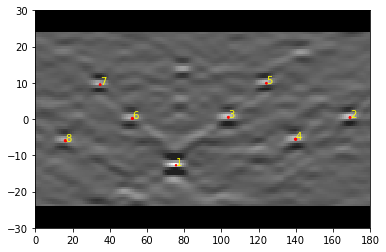

Band Vote Time:  0.501627013000018
num cpu/gpu: 36 2


2022-05-02 18:20:11,871	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


In [6]:
f = h5py.File('/Users/dave/Desktop/SLMtest/scan2v3_NLPAR_l0.90sr3.oh5', 'r') # this is an HDF5 file type used by EDAX.  
h5pats = f['/scan2v3/EBSD/Data/Pattern'] # location of the pattern array within the HDF5 file.  

h5data, h5bnddata, indxer=ebsd_index.index_pats(patsIn = h5pats[0:1000,:,:],
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 2)
indxer.bandDetectPlan.useCPU = True
h5data, h5banddata = ebsd_index.index_pats_distributed(patsIn = h5pats, chunksize = 1008, ncpu = 36, ebsd_indexer_obj = indxer)